# Exploratory Data Analysis

In [2]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.0f' % x)

## Anime Dataset

In [3]:
# import anime dataset
anime_df = pd.read_csv("datasets/cleaned_anime.csv")
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9,793665
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9,114262
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9,93351


In [4]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9,793665
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9,114262
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9,93351
...,...,...,...,...,...,...,...
3782,34522,"Wake Up, Girls! Shin Shou","Drama, Music",TV,nan,nan,381
3783,34467,Yami Shibai 4th Season,"Dementia, Horror, Supernatural",TV,nan,nan,1838
3784,32615,Youjo Senki,"Magic, Military",TV,nan,nan,6652
3785,34284,Yuuki Yuuna wa Yuusha de Aru: Washio Sumi no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,nan,2593


In [5]:
# measures of central tendencies
anime_df[["episodes", "rating", "members"]].describe()

,episodes,rating,members
count,3578,3671,3787
mean,36,7,42684
std,81,1,89121
min,2,3,12
25%,12,6,483
50%,24,7,5947
75%,39,7,44246
max,1818,10,1013917


In [6]:
# modes of each numerical category
mode = anime_df[["episodes", "rating", "members"]].mode()
mode.rename(index={0: "mode"})

,episodes,rating,members
mode,12,6,102


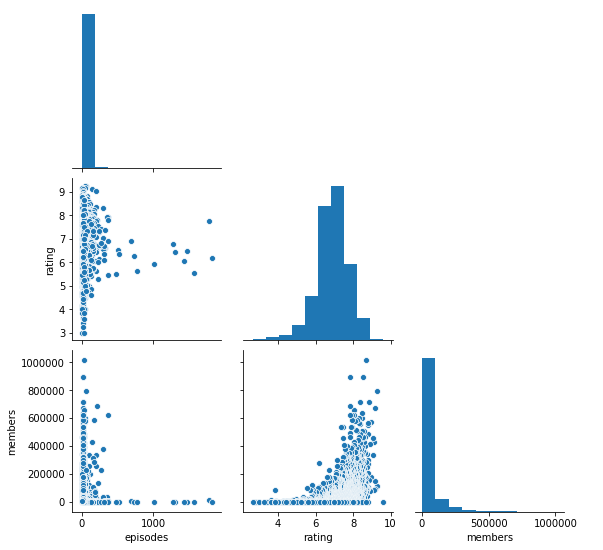

In [7]:
# pairplot
sns.pairplot(data = anime_df, vars=["episodes","rating", "members"], corner=True)

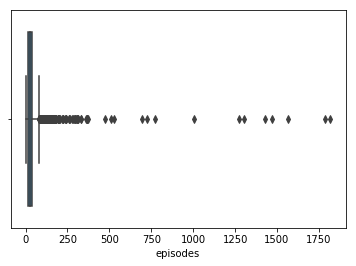

In [8]:
#boxplot of number of episodes
sns.boxplot(data=anime_df, x="episodes")
plt.show()

Looking at the histograms on the pair plot, we see that the distribution of ratings for shows seem to be **slightly left skewed** while the number of members seem to be **heavily right skewed**. These are also supported by the measures of central tendency. For the ratings, we see a **mode of 6**, a **median of 7**, and a **mean of 7**. Although numerically it seems reasonably symmetrically distributed, we say that visually it is quite obviously left skewed. This is most likely because the range of values is very small and so the distribution of the ratings data is not obvious when only using the mean, median, and mode. On the other hand the number of members has a **mode of 102**, **median of 5947**, and a **mean of 42684** justifying the assumption that it is heavily right skewed. The histogram for the number of episodes has extremely low frequencies of animes with high numbers of episodes however, looking at the boxplot and the numerical data, we see that the distribution is **left skewed** with a **mode of 12**, a **median of 24**, and a **mean of 36**.

All three distributions of the numerical data may suggest that some form of transformation may be required before building the recommendation system.

Regarding any correlations, it seems that there are no obvious correlations between the number of episodes and the amount of members, and also there seems to be no clear correlation between number of episodes and their average ratings. There does seem to a possible weak positive exponential relationship between the average rating a show gets compared to the number of members.  

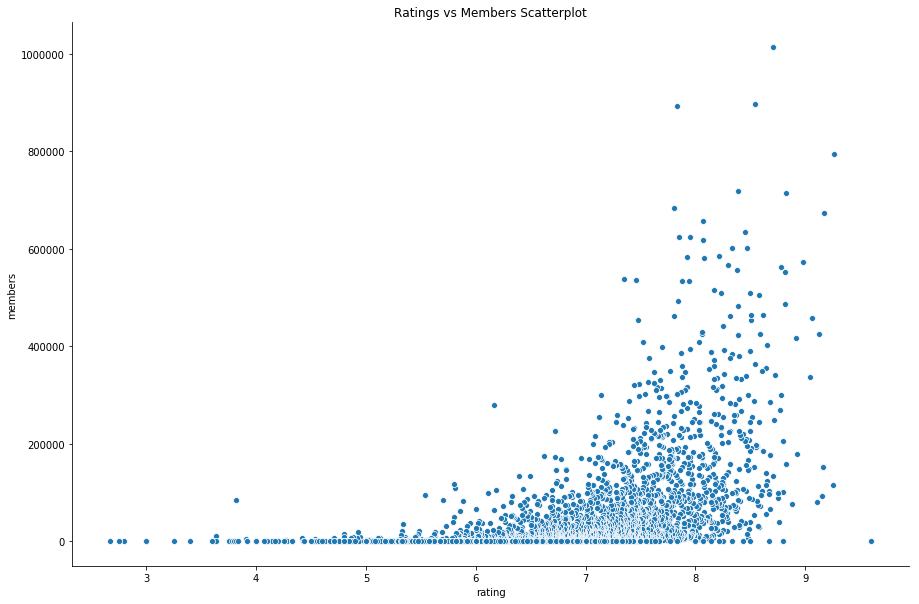

In [19]:
#plot ratings vs members
plt.figure(figsize=(15,10))
sns.scatterplot(data=anime_df, x="rating", y="members")
plt.title("Ratings vs Members Scatterplot")
sns.despine()
plt.show()

In [10]:
# function to count the freq of animes for each genre
def count_genre_freq(df, column, delimiter=", "):
    from collections import Counter
    non_empty_rows = df[df[column].isnull() == False][column]
    row_counted = non_empty_rows.str.split(", ").apply(Counter)
    total_freq = dict(sum(row_counted, Counter()))
    freq_series = pd.Series(total_freq)
    output = freq_series.sort_values(ascending=False)
    return output

In [11]:
# Find total number of animes in the dataset that belong to a certain genre
animes_per_genre = count_genre_freq(anime_df, "genre")
animes_per_genre

Comedy           1870
Action           1098
Adventure         932
Sci-Fi            774
Fantasy           765
Shounen           712
Drama             697
Romance           652
School            567
Slice of Life     562
Kids              484
Supernatural      431
Mecha             379
Magic             353
Shoujo            283
Historical        275
Ecchi             245
Sports            240
Seinen            235
Mystery           222
Super Power       190
Harem             175
Military          133
Parody            126
Space             123
Music             123
Horror            113
Game              103
Martial Arts       95
Demons             89
Psychological      89
Samurai            51
Police             50
Vampire            46
Cars               36
Thriller           34
Josei              32
Shoujo Ai          31
Shounen Ai         24
Dementia            9
dtype: int64

In [12]:
# top 5 most frequent genres
animes_per_genre.head()

Comedy       1870
Action       1098
Adventure     932
Sci-Fi        774
Fantasy       765
dtype: int64

In [13]:
# 5 least frequent genres
animes_per_genre.tail()

Thriller      34
Josei         32
Shoujo Ai     31
Shounen Ai    24
Dementia       9
dtype: int64

It seems as though the 5 most frequent anime genres of the dataset are **Comedy, Action, Adventure, Sci-Fi, and Fantasy** while the genres with the lowest frequencies are **Thriller, Josei, Shoujo Ai, Shounen Ai, and Dementia**.

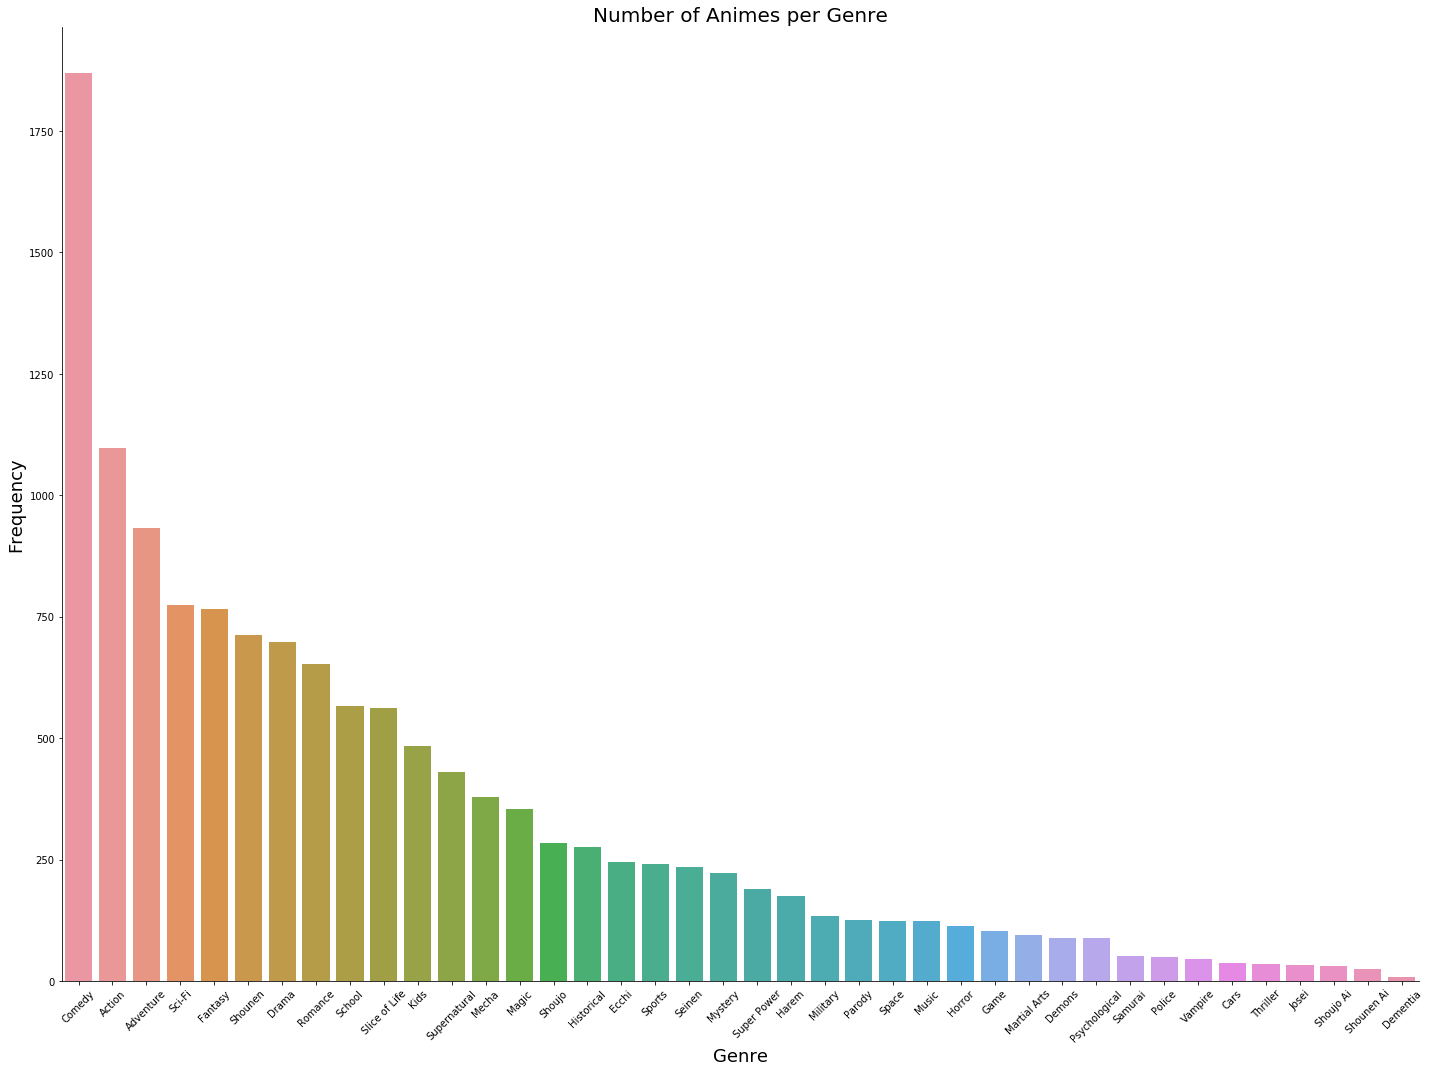

In [20]:
# plot the number of animes per genre
plt.figure(figsize=(20,15))
sns.barplot(x=animes_per_genre.index, y=animes_per_genre.values)
plt.xlabel("Genre", size=18)
plt.ylabel("Frequency", size=18)
plt.xticks(rotation=45)
plt.title("Number of Animes per Genre", size=20)
plt.tight_layout()
sns.despine();